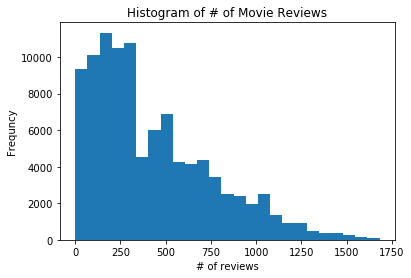

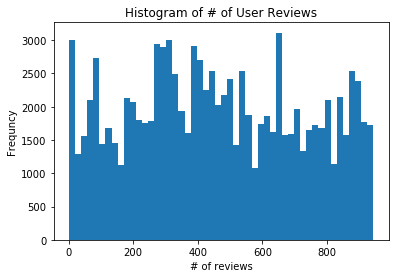


The histogram of the number of movie reviews looks somewhat like a beta distribution,
while the histogram for the number of user reviews doesn't follow an easily recognized
distribution. It looks strangely uniform suggesting that you can't easily tell if a
user is going to review a lot of movies or not. The opposite seems to be true for the
number of movie reviews, though, which makes intuitive sense. 



In [1]:
# HW2 Q1
# and here... we... go...

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import random

# Reading in the data 
data = pd.read_table('u.data',names=['userID','itemID','rating','ts'])

# create histogram of the number of movie reviews
plt.hist(data['itemID'],25)
plt.xlabel('# of reviews')
plt.ylabel('Frequncy')
plt.title('Histogram of # of Movie Reviews')
plt.show()

# create histogram of the number of reviews by each user
plt.hist(data['userID'],50)
plt.xlabel('# of reviews')
plt.ylabel('Frequncy')
plt.title('Histogram of # of User Reviews')
plt.show()

# Discussion

print('''
The histogram of the number of movie reviews looks somewhat like a beta distribution,
while the histogram for the number of user reviews doesn't follow an easily recognized
distribution. It looks strangely uniform suggesting that you can't easily tell if a
user is going to review a lot of movies or not. The opposite seems to be true for the
number of movie reviews, though, which makes intuitive sense. 
''')


In [2]:
# Building a recommender system, part A

# Read in data
train = pd.read_table('ua.base',names=['userID','itemID','rating','ts'])
test = pd.read_table('ua.test',names=['userID','itemID','rating','ts'])

## Create matrix A ##
# rows of A correspond to users
# cols of A correspond to movies
# the u,ith element of A is user u's rating of movie i
# if the uth user has not rated the ith movie then A_u,i is NaN
trainA = train.pivot(columns='itemID', index='userID', values='rating')
testA = test.pivot(columns='itemID', index='userID', values='rating')

# add missing movies from training set to testing set, srsly so annoying
missingFromTrain = testA.ix[:,~testA.columns.isin(trainA.columns)]
trainA = pd.concat([trainA,missingFromTrain], axis=1, join_axes=[trainA.index])

In [3]:
## Build baseline recommender system ##
# predicted ratings are defined as b_u,i = mu + b_u + b_i
# mu is the overall average rating
# b_u is the training deviation of the user u
# b_i is the training deviation of the movie i

# calculate mu
def calc_mu(trainSet):
    sumRatings = trainSet.sum().sum()
    numRatings = trainSet.count().sum()
    mu = sumRatings/numRatings
    return mu

# calculate b_i
def calc_b_i(movie, mu, lambda2):
    'Calculate the b_i value for the input movie Series'

    deviance = movie-mu
    numerator = deviance.sum()
    denominator = movie.count() + lambda2
    return numerator/denominator

# calculate b_u
def calc_b_u(user, all_b_i, mu, lambda3):
    'Calculate the b_u value for the input user Series'
    
    deviance = user - mu - all_b_i
    numerator = deviance.sum()
    denominator = user.count() + lambda3
    return numerator/denominator

# calculate b_u,i
def calc_b_u_i(loc, all_b_u, all_b_i, mu):
    '''Calculate the b_u,i value for all u,i paris,
    
    function is a little clunky in order to work with pandas' applymap
    '''
    u = loc.itemID
    i = loc.userID
    try:
        b_u = all_b_u[u]
    except KeyError:
        b_u = 0
    
    try:
        b_i = all_b_i[i]
    except KeyError:
        b_i = 0
    
    b_u_i = mu + b_u + b_i
    return (u,i,b_u_i)

def calc_RMSE(true, predicted):
    '''Calculate the RMSE of the input arguments.

    predicted and true are stacked dataframes with columns:
    itemID, userID, b_u,i/rating, respectively
    '''
    
    # join data to align it and ensure accurate coupling
    allData = pd.concat([true, predicted], axis=1, join='inner')
    
    # calculate RMSE step-by-step 
    difference = allData['b_u_i'] - allData['rating']
    difference_sq = difference**2
    difference_sum = difference_sq.sum()
    mean = difference_sum/len(allData.index)
    sqrt_mean = mean**(1/2)
    return sqrt_mean


In [4]:
# estimate values for mu, b_u, and b_i
lambda2 = 25 # from paper
lambda3 = 10 # from paper
mu = calc_mu(trainA)

In [5]:
b_i= trainA.apply(calc_b_i, 0, mu=mu, lambda2=lambda2)

In [6]:
b_u = trainA.apply(calc_b_u, 1, mu=mu, all_b_i=b_i, lambda3=lambda3)
print(b_u)

userID
1      0.032689
2      0.086408
3     -0.402614
4      0.544406
5     -0.475944
6     -0.147667
7      0.386619
8      0.216700
9      0.256950
10     0.406457
11    -0.090973
12     0.445695
13    -0.368532
14     0.301319
15    -0.429054
16     0.600053
17    -0.275261
18     0.132914
19     0.023708
20    -0.334027
21    -0.557281
22    -0.082303
23    -0.056023
24     0.521023
25     0.141751
26    -0.463825
27    -0.109867
28     0.127611
29     0.187177
30     0.230959
         ...   
914   -0.126941
915   -0.259706
916   -0.176534
917   -0.072600
918   -0.343367
919   -0.041843
920   -0.277697
921   -0.173014
922   -0.116042
923    0.662991
924   -0.041208
925   -0.216639
926   -0.087575
927    0.257788
928    0.562105
929   -0.255463
930   -0.475500
931    0.133757
932    0.250005
933   -0.880181
934    0.049745
935    0.378727
936    0.278795
937   -0.287206
938   -0.010013
939    0.760708
940   -0.235728
941    0.141760
942    0.484521
943   -0.088444
dtype: float64


In [7]:
# calculate b_u,i of testing set
dfTest = pd.DataFrame(testA.stack().index.tolist(),
                      columns=['itemID','userID'])

test_b_u_i = test[['userID','itemID']].apply(calc_b_u_i, axis=1, all_b_u=b_u,
                                             all_b_i=b_i, mu=mu)
testPred = pd.DataFrame(test_b_u_i.apply(pd.Series))
testPred.columns = ['itemID','userID','bui']

In [8]:
# calculate RMSE
from sklearn.metrics import mean_squared_error

In [9]:
joined = pd.concat([test, testPred], join='inner', axis=1)
print('RMSE')
print((mean_squared_error(joined['rating'], joined['bui']))**(1/2))

RMSE
1.23670932283


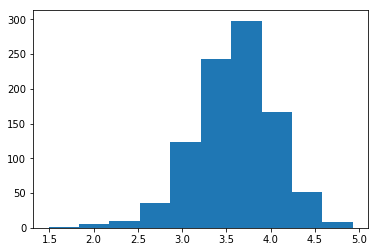

Majority of the density is in the interval 2.5 to 5. So we use this interval.


In [10]:
# part c

# find the average rating per user in the test set
plt.hist(trainA.mean(axis=1))
plt.show()

print('Majority of the density is in the interval 2.5 to 5. So we use this interval.')

In [11]:
# generate flags that denote which users are in which category

interval_size = (5.0-2.5)/5.0
def group_gen(avg_rating):
    ''' Returns the group number of a user based on their mean rating.
    
    Group 1: [2.5,3.0)
    Group 2: [3.0,3.5)
    Group 3: [3.5,4.0)
    Group 4: [4.0,4.5)
    Group 5: [4.5,5.0)
    '''
    
    if 2.5 <= avg_rating < 3.0:
        return 1
    elif 3.0 <= avg_rating < 3.5:
        return 2
    elif 3.5 <= avg_rating < 4.0:
        return 3
    elif 4.0 <= avg_rating < 4.5:
        return 4
    elif 4.5 <= avg_rating:
        return 5

groups = testA.mean(axis=1).apply(group_gen)
intervals = [(2.5,3.0), (3.0,3.5), (3.5,4.0), (4.0,4.5), (4.5,5.0)]

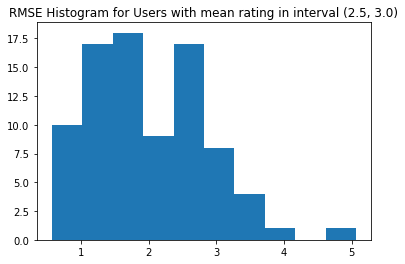

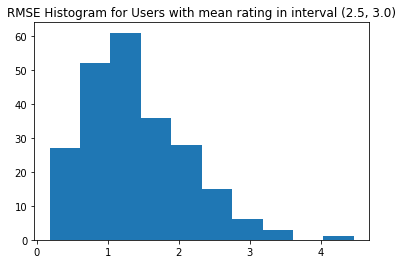

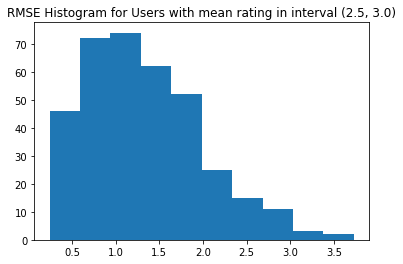

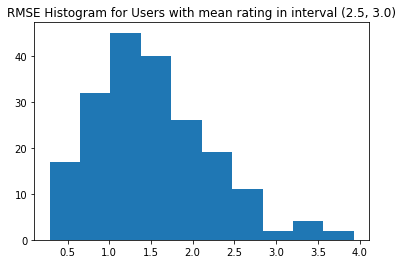

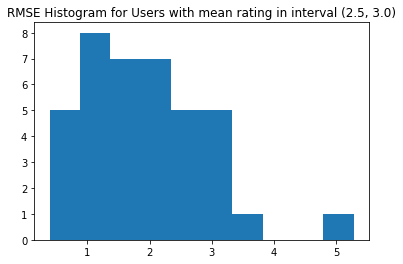

In [12]:
count = 0
output = pd.DataFrame(columns=['userID','avg rating', 'RMSE'])
for flag in range(1,6):
    
    # get all userIDs in this bucket
    group_indexes = list(groups[groups == flag].index)
    # extract info from test set
    thisTest = test[['userID','itemID', 'rating']]
    ratings = thisTest[ thisTest['userID'].isin(group_indexes)]
    
    # extract info from predicted set
    this_bui = testPred[['userID','itemID', 'bui']]
    this_bui = this_bui[ this_bui['userID'].isin(group_indexes)]
    
    # join info together
    thisJoined = pd.concat([ratings, this_bui], join='inner', axis=1)

    thisJoined = thisJoined.ix[:,[0,2,5]]
    grouped = thisJoined.groupby('userID')
    theseRMSE = []
    theseMeans = []
    for user,group in grouped:
        rmse = mean_squared_error(group['rating'],group['bui'])**(1/2)
        theseRMSE.append(rmse)
        theseMeans.append(group['rating'].mean())
    plt.hist(theseRMSE)
    plt.title('RMSE Histogram for Users with mean rating in interval {}'.format(intervals[count]))
    plt.show()

In [15]:
# building recommender system based on section 4.2 of the paper

# defining the similarity function

def calcSim(pair):
    
    i1 = pair[0]
    i2 = pair[1]
    
    if i2 % 100 == 0:
        print(i1,i2)
    
    # calc intersection of users who have rated i1 and i2
    i1NotNull = trainA.ix[ trainA[i1].notnull() , i1]
    i2NotNull = trainA[ trainA[i2].notnull() ].index
    intersection = i1NotNull[ i1NotNull.index.isin(i2NotNull) ].index
    
    # calc mean rating of users in intersection
    meanRatings = trainA.ix[intersection, :].mean(axis=1)
    
    #calculate numerator
    i1MeanDev = trainA.ix[intersection,i1] - meanRatings
    i2MeanDev = trainA.ix[intersection,i2] - meanRatings
    meanDevProd = i1MeanDev*i2MeanDev
    numerator = meanDevProd.sum()
    
    # calculate denominator
    i1SumMeanDevSq = ((trainA.ix[intersection,i1] - meanRatings)**2).sum()
    i2SumMeanDevSq = ((trainA.ix[intersection,i2] - meanRatings)**2).sum()
    denominator = (i1SumMeanDevSq*i2SumMeanDevSq)**(1/2)
    
    # case when numerator is 0, as described on piazza
    # if there's only one user who rated a pair of movies, and it's identical to their
    # mean rating, then the numerator will be 0
    # thus, it's reasonable to assume the similarity to be 1
    if numerator == 0:
        return 1
    
    return(numerator/denominator)
    

In [19]:
# creating the item similarity matrix
import itertools
movies = trainA.columns.sort_values().tolist()
moviePairs = pd.DataFrame(list(itertools.combinations(movies,2)))
moviePairs.columns = ['i1','i2']

In [20]:
movieSim = moviePairs.apply(calcSim,axis=1)


1 100
1 200
1 300
1 400
1 500
1 600
1 700
1 800
1 900
1 1000
1 1100
1 1200
1 1300
1 1400
1 1500
1 1600
2 100
2 200
2 300
2 400
2 500
2 600
2 700
2 800
2 900
2 1000
2 1100
2 1200
2 1300
2 1400
2 1500
2 1600
3 100
3 200
3 300
3 400
3 500
3 600
3 700
3 800
3 900
3 1000
3 1100
3 1200
3 1300
3 1400
3 1500
3 1600
4 100
4 200
4 300
4 400
4 500
4 600
4 700
4 800
4 900
4 1000
4 1100
4 1200
4 1300
4 1400
4 1500
4 1600
5 100
5 200
5 300
5 400
5 500
5 600
5 700
5 800
5 900
5 1000
5 1100
5 1200
5 1300
5 1400
5 1500
5 1600
6 100
6 200
6 300
6 400
6 500
6 600
6 700
6 800
6 900
6 1000
6 1100
6 1200
6 1300
6 1400
6 1500
6 1600
7 100
7 200
7 300
7 400
7 500
7 600
7 700
7 800
7 900
7 1000
7 1100
7 1200
7 1300
7 1400
7 1500
7 1600
8 100
8 200
8 300
8 400
8 500
8 600
8 700
8 800
8 900
8 1000
8 1100
8 1200
8 1300
8 1400
8 1500
8 1600
9 100
9 200
9 300
9 400
9 500
9 600
9 700
9 800
9 900
9 1000
9 1100
9 1200
9 1300
9 1400
9 1500
9 1600
10 100
10 200
10 300
10 400
10 500
10 600
10 700
10 800
10 900
10 1000
10

In [36]:
moviePairs.sim = movieSim
moviePairs['sim'] = movieSim
moviePairsPivot = moviePairs.pivot(index='i1', columns='i2', values='sim')

In [101]:
# predict rating function

def predRating(ui, k):

    user = ui[0]
    item = ui[1]
    
    # get all ratings of movies for the input user
    userRatings = trainA.ix[user,:]
    userRatings = userRatings[ userRatings.notnull() ]
    
    # get similarity scores between movies rated and item arg
    moviesRated = list(userRatings.index)
    
    # get top k most similar movies and their ratings
    simScores = []
    for movie in moviesRated:
        # skip identical movies
        if movie==item:
            continue
        i1 = min(item,movie)
        i2 = max(item,movie)
        score = moviePairsPivot.ix[i1,i2]
        rating = userRatings.ix[movie]
        simScores.append((rating,score,movie))
    simScores.sort(key=lambda x: x[1])
    topKScores = simScores[-k:]
    
    # calculate predicted rating
    numerator = sum([i*j for i,j,k in topKScores])
    denominator = sum([abs(score) for rating,score,movie in topKScores])
    
    return round(numerator/denominator)
    

In [102]:
# evaluate using testing data

predRatings1 = test[ ['userID','itemID'] ].apply(predRating, k=1, axis=1)
predRatings2 = test[ ['userID','itemID'] ].apply(predRating, k=2, axis=1)
predRatings3 = test[ ['userID','itemID'] ].apply(predRating, k=3, axis=1)
predRatings5 = test[ ['userID','itemID'] ].apply(predRating, k=5, axis=1)
predRatings10 = test[ ['userID','itemID'] ].apply(predRating, k=10, axis=1)

In [103]:
from sklearn.metrics import mean_squared_error

In [110]:
# calculate RMSE
trueRatings = test['rating']
rmse1 = mean_squared_error(trueRatings,predRatings1)**(1/2)
rmse2 = mean_squared_error(trueRatings,predRatings2)**(1/2)
rmse3 = mean_squared_error(trueRatings,predRatings3)**(1/2)
rmse5 = mean_squared_error(trueRatings,predRatings5)**(1/2)
rmse10 = mean_squared_error(trueRatings,predRatings10)**(1/2)

print('RMSE (k=1):',rmse1)
print('RMSE (k=2):',rmse2)
print('RMSE (k=3):',rmse3)
print('RMSE (k=5):',rmse5)
print('RMSE (k=10):',rmse10)

print('KNN Predictor with k=5 yields the lowest RMSE at',rmse5)

RMSE (k=1): 1.39989395144
RMSE (k=2): 1.25886043167
RMSE (k=3): 1.17818632298
RMSE (k=5): 1.1330380336
RMSE (k=10): 1.36952902711
KNN Predictor with k=5 yields the lowest RMSE at 1.1330380336


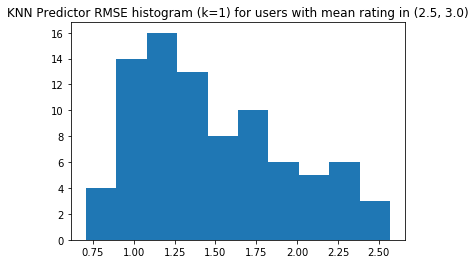

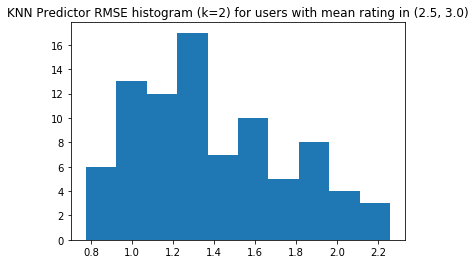

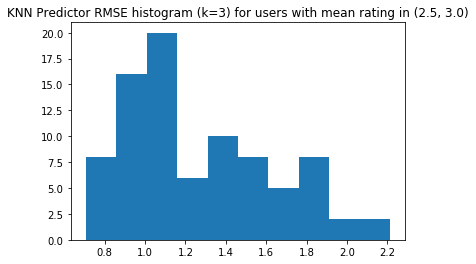

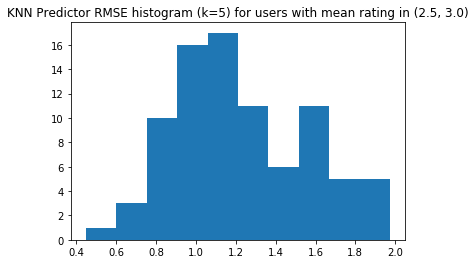

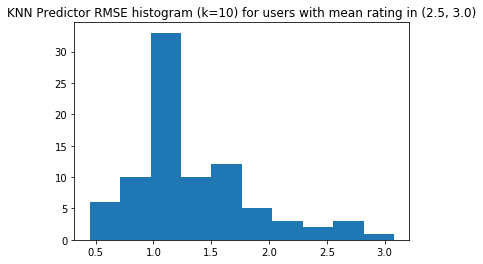

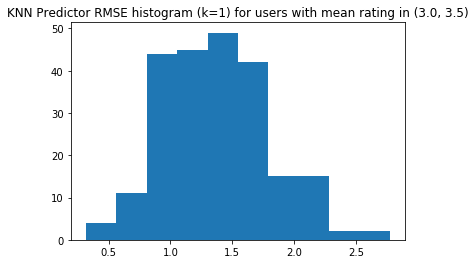

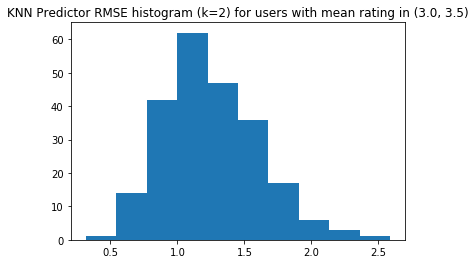

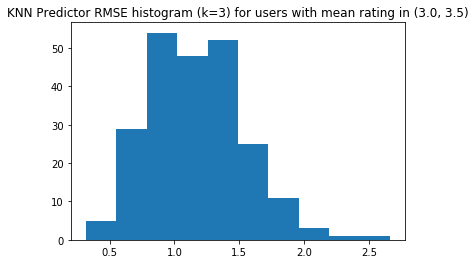

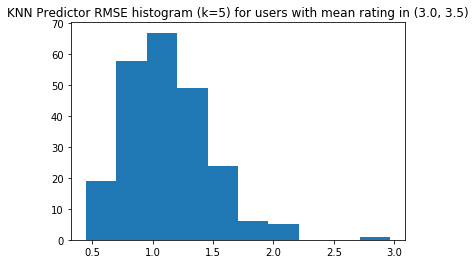

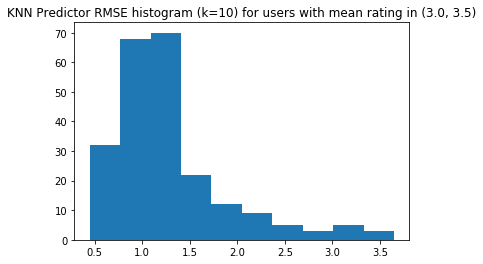

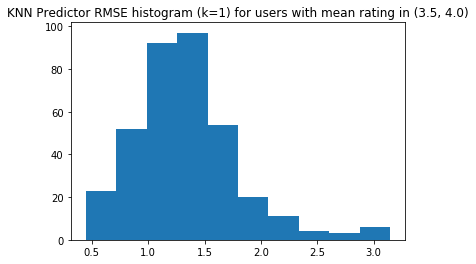

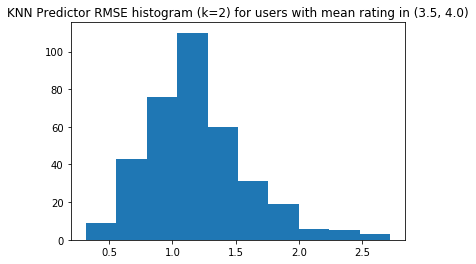

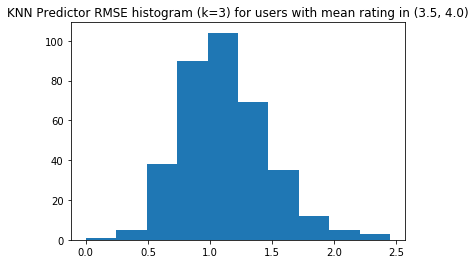

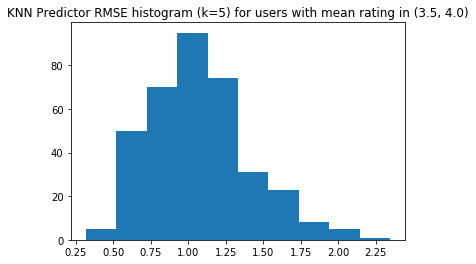

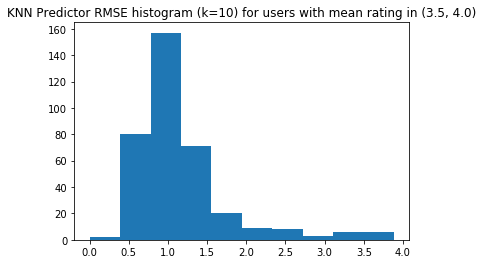

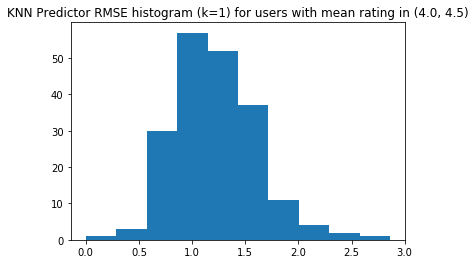

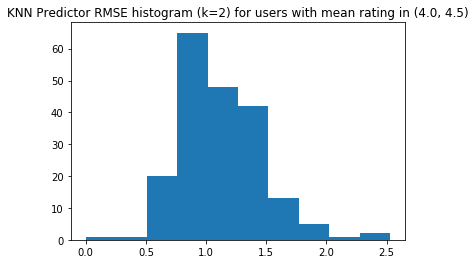

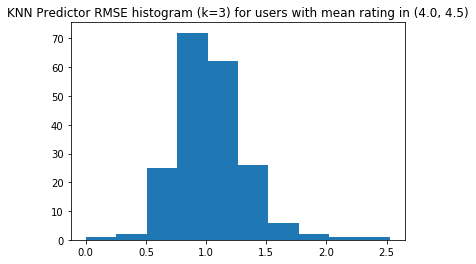

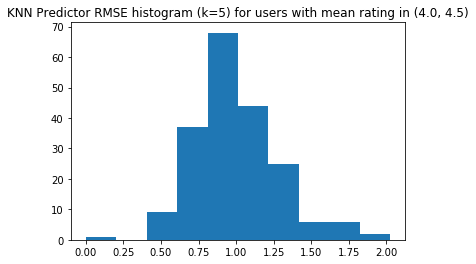

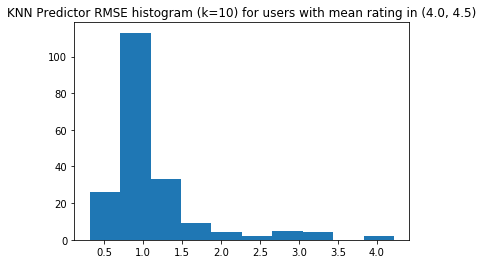

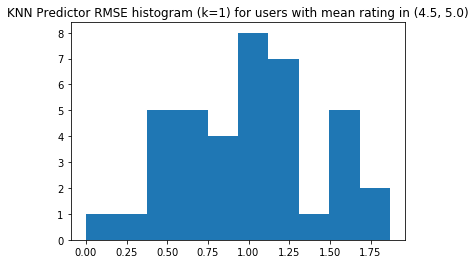

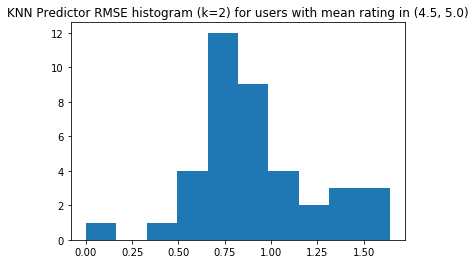

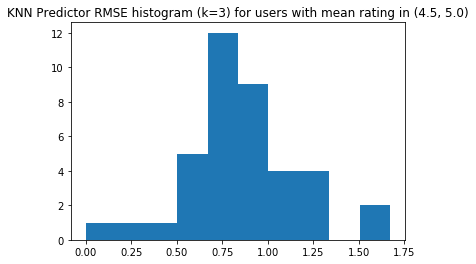

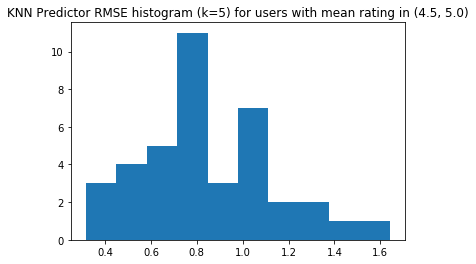

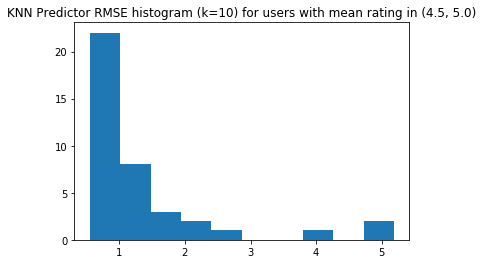

In [119]:
# calc RMSE per user group & plot histogram

count = 0
for flag in range(1,6):

    
    # get all userIDs in this bucket
    group_indexes = list(groups[groups == flag].index)
    # extract info from test set
    thisTest = test[['userID','itemID', 'rating']]
    ratings = thisTest[ thisTest['userID'].isin(group_indexes) ]
    
    # predict ratings for all users and movies in this group for each value of k
    for k in [1,2,3,5,10]:
        rmseList = []
        for user in ratings[ 'userID' ].unique():
            userRatings = ratings[ ratings['userID'] == user ]
            tempPred = userRatings[ ['userID', 'itemID'] ].apply(predRating, k=k, axis=1)
            rmse = mean_squared_error(userRatings['rating'],tempPred)**(1/2)
            rmseList.append(rmse)
        plt.hist(rmseList)
        plt.title('KNN Predictor RMSE histogram (k={}) for users with mean rating in {}'.format(k,intervals[count]))
        plt.show()
    count += 1
    